<div class="admonition abstract">
<p class="admonition-title">Requirements</p>
    <ul>
        <li>python>=3.11</li>
        <li>pandas==2.3.0</li>
        <li>seaborn==0.13.2</li>
        <li>matplotlib==3.10.3</li>
        <li>numpy==2.3.1</li>
    </ul>
</div>

<div class="admonition input">
    <p class="admonition-title">Input data</p>
    <ul>
     <li><a href=https://github.com/KTest-VN/lps_paper/tree/main/evaluation/downstream/data/raw_snpwise_accuracy>LPS-arrays evaluation output</a></li>
     </ul>
</div>

## Processing raw data

In [1]:
## Import Python packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Input variables
raw_lps_res = '../../../evaluation/downstream/data/raw_snpwise_accuracy/lps_all_cov.txt'
raw_arr_res = '../../../evaluation/downstream/data/raw_snpwise_accuracy/array_all_cov.txt'

output_figs_folder = '../../../evaluation/downstream/out_figs/lps_performance'
output_table_folder = '../../../evaluation/downstream/out_tables/lps_performance/coverage'

In [3]:
def get_lps(s):
    """
    Extracts population and model identifier from a file name (LPS-style).
    Example input: "result_model1_array1_EUR.txt"
    Output: "EUR_model1"
    """
    t = s.split('_')
    return f'{t[3].upper()}_{t[2]}'

def get_array(s):
    """
    Extracts array name from a file name (Array-style).
    Example input: "result_model1_PMRA_EUR.txt"
    Output: "PMRA"
    """
    t = s.split('_')
    return f'{t[2]}'    

In [4]:
def process_perbin(path, array=None):
    """
    Process a per-bin results file and return a standardized long-format DataFrame.

    Parameters:
    - path (str): Path to the tab-separated result file.
    - array (bool): True if the file is from an array dataset, False (default) if from an LPS dataset.

    Returns:
    - pd.DataFrame: Long-format data with columns ['file', 'bins', 'value', 'array', 'pop', 'type']
    """
    # Read the file into a DataFrame with no header
    df = pd.read_csv(path, header=None, sep='\t')

    # Rename columns: 'file' for the file identifier, followed by bins
    df.columns = ["file", "(0–0.01]", "(0.01–0.05]", "(0.05–0.5]", "(0.01–0.5]"]

    # Melt the DataFrame to long format: one row per bin per file
    df = pd.melt(df, id_vars=['file'], var_name='bins')

    if array:
        # Standardize array naming from various vendor-specific labels
        df['file'] = df['file'].replace(regex={
            'Axiom_PMRA': 'PMRA',
            'Axiom_JAPONICA': 'JAPONICA',
            'infinium-omni2.5.v1.5': 'OMNI2.5',
            'cytosnp-850k-v1.2': 'CYTOSNP',
            'global-screening-array-v.3': 'GSA',
            'infinium-omni5-v1.2': 'OMNI5',
            'Axiom_PMDA': 'PMDA',
            'Axiom_UKB_WCSG': 'UKB-WCSG'
        })

        # Extract array name and population code
        df['array'] = [get_array(i) for i in df['file']]
        df['pop'] = [i.split('_')[3] for i in df['file']]

        # Normalize naming for UKB_WCSG
        df['array'] = df['array'].replace(regex={
            'UKB-WCSG': 'UKB_WCSG'
        })

        df['type'] = 'array'
    else:
        # Extract composite identifier and population for LPS
        df['array'] = [get_lps(i) for i in df['file']]
        df['pop'] = [i.split('_')[4] for i in df['file']]
        df['type'] = 'lps'

    return df 

In [5]:
# Process both LPS and array results
lps_res = process_perbin(raw_lps_res)
array_res = process_perbin(raw_arr_res, array=True)

In [6]:
# Combine both results into a single DataFrame
data = pd.concat([lps_res, array_res])

Show the first few rows of the merged dataset

In [7]:
data.head()

,file,bins,value,array,pop,type
0,perbin_chr10_0.5_lps_AFR_snp_wise.acc_cov.txt,(0–0.01],0.573309,LPS_0.5,AFR,lps
1,perbin_chr10_0.5_lps_AMR_snp_wise.acc_cov.txt,(0–0.01],0.725847,LPS_0.5,AMR,lps
2,perbin_chr10_0.5_lps_EAS_snp_wise.acc_cov.txt,(0–0.01],0.331660,LPS_0.5,EAS,lps
3,perbin_chr10_0.5_lps_EUR_snp_wise.acc_cov.txt,(0–0.01],0.530053,LPS_0.5,EUR,lps
4,perbin_chr10_0.5_lps_SAS_snp_wise.acc_cov.txt,(0–0.01],0.400177,LPS_0.5,SAS,lps


## Plotting data

In [8]:
def do_filter_data(data, bins, pop):
    """
    Filter data by MAF bin and population
    """
    pick = (data['bins'] == bins) & (data['pop'] == pop)
    return data[pick]

In [9]:
# Desired array/LPS order for consistent plotting
desired_order = ['GSA', 
                'JAPONICA',
                'UKB_WCSG',
                'CYTOSNP', 
                'PMRA', 
                'PMDA',
                'OMNI2.5', 
                'OMNI5',
                'LPS_0.5',
                'LPS_0.75',
                'LPS_1.0',
                'LPS_1.25',
                'LPS_1.5',
                'LPS_2.0'] 

In [10]:
def plot_1(data, bins, pop, axe):
    """
    Generate a boxplot for one bin/pop combination on the given axis.
    """
    filterd_data = do_filter_data(data, bins, pop)
    sns.boxplot(data=filterd_data, 
                y = 'array', 
                x = 'value', 
                hue='type', fill=False,
                width=0.4,
                order=desired_order,
                fliersize= 0.5,
                orient='h',
                ax=axe)
    threshold = filterd_data[filterd_data['array'] == 'GSA']['value'].median()
    axe.axvline(threshold, 0, 10, c='r', linestyle ="--", linewidth = 1)
    axe.grid(axis='both', linewidth=0.5)
    axe.legend().set_visible(False)

In [11]:

def full_plot(data):
    """
    Generate a full grid of plots, one per (bin, pop) combination.
    """
    cols = data['bins'].unique()
    rows = data['pop'].unique()
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), figsize=(11,13))

    for i, x in enumerate(rows):
        for j, y in enumerate(cols):
            plot_1(data, y, x, axes[i,j])
            
            # Ticks
            axes[i,j].set_xlim(0, 1.01)
            axes[i,j].set_xticks(np.arange(0, 1.01, 0.2))
            axes[i,j].set_ylabel("")
            axes[i,j].set_xlabel("")
            
            if j != 0:
                pass
                
            if i == 0:
                # Title
                axes[i,j].set_title(label=y, 
                            color='white', 
                            bbox=dict(facecolor='#b3b3b3', edgecolor='white', boxstyle='round,pad=0.6'), 
                            x=0.5, pad=12,
                            fontdict={'fontsize':10})
            if j == 0:
                axes[i,j].set_ylabel(ylabel=x,
                                                color='white',
                                                labelpad = 12,
                                                rotation = 'horizontal', 
                                                bbox=dict(facecolor='#b3b3b3', 
                                                          edgecolor='white', 
                                                          boxstyle='round,pad=0.6'),
                                                fontdict={'fontsize':10})
            
    for line_num, line_axis in enumerate(axes):
        for col_num, ax in enumerate(line_axis):
            if col_num == 0:
                continue
            ax.set_ylim(line_axis[0].get_ylim()) # align axes
            plt.setp(ax.get_yticklabels(), visible=False)
                
    
    fig.tight_layout(rect=[0.02, 0.02, 1, 1])
    plt.savefig(f'{output_figs_folder}/cov.pdf', dpi=300)


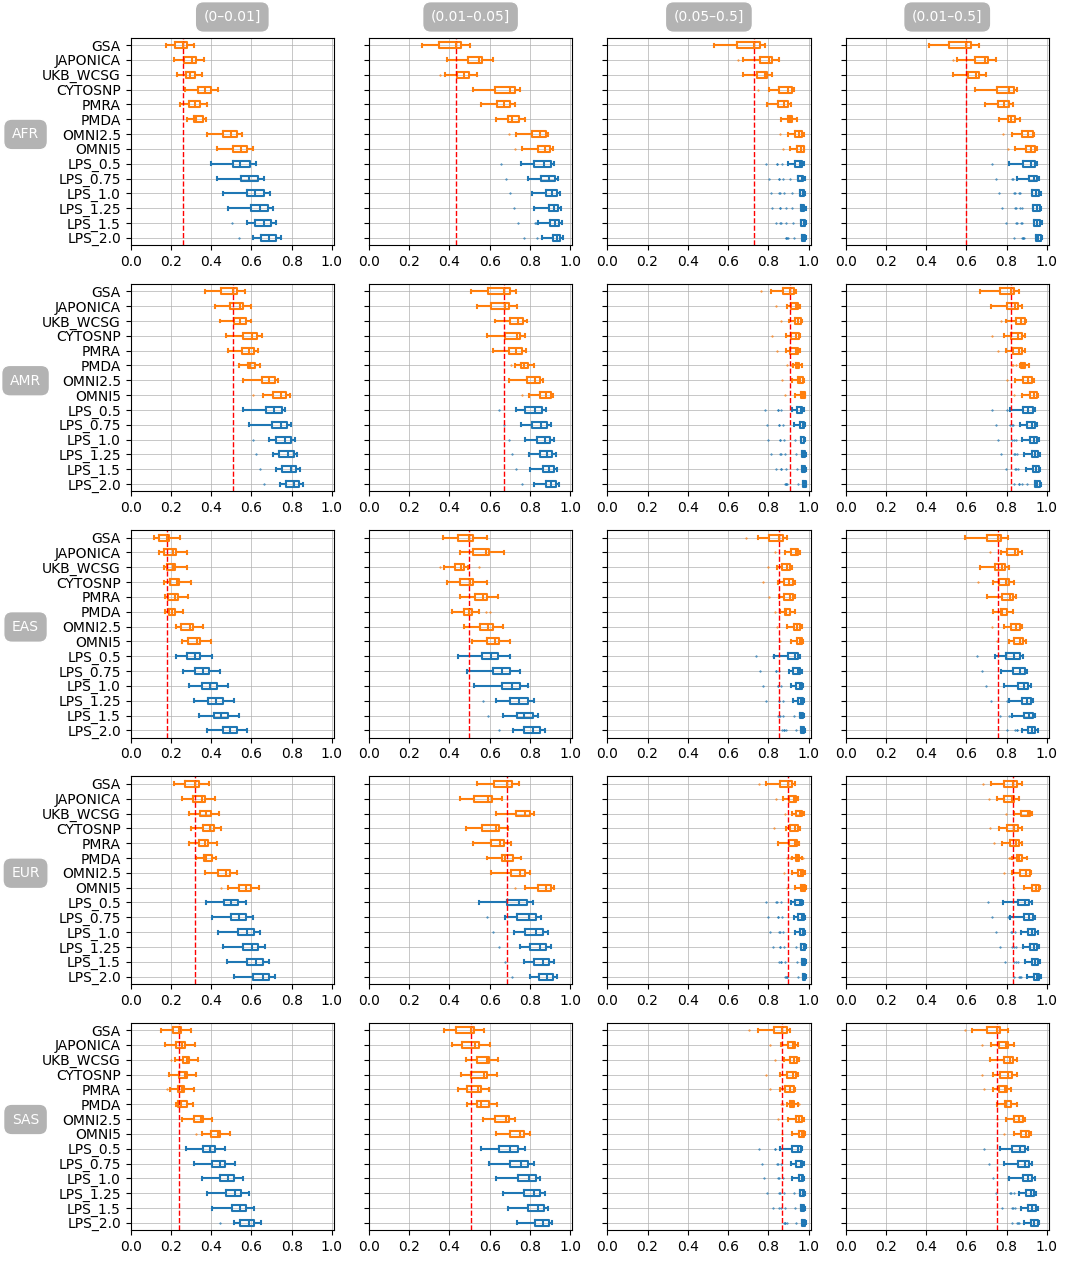

In [12]:
full_plot(data)

## Data Exporter

In [13]:
df = data
# Compute group-wise mean and standard deviation
summary = df.groupby(["type", "bins", "array", "pop"]).agg(
    mean=("value", "mean"),
    std=("value", "std")
).reset_index()

# Format summary into "mean ± std" string
summary["formatted"] = summary.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)

# Convert to a wide-format table: each population is a column
result = summary.pivot(index=["bins", "array"], columns="pop", values="formatted").reset_index()

# Ensure arrays are ordered as defined
result["array"] = pd.Categorical(result["array"], categories=desired_order, ordered=True)
result = result.sort_values(["bins", "array"])

# Export separate CSV files for each bin
for bin_val, df_bin in result.groupby("bins"):
    df_bin = df_bin.drop(columns=["bins"])
    df_bin = df_bin.rename(columns={'array': 'Array/LPS'})
    df_bin.to_csv(f"{output_table_folder}/coverage_summary_bin_{bin_val}.csv", index=False)

<div class="admonition output">
    <p class="admonition-title">Outputs</p>
    <ul>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_tables/lps_performance/coverage">LPS coverage-evaluation tables</li>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_figs/lps_performance/Fig3_cov.pdf">LPS accurate-evaluation plot</li>
    </ul>
</div>